<a href="https://colab.research.google.com/github/HJJunn/distribution_forecasting/blob/main/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [193]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [200]:
df = pd.read_csv('/content/df (1).csv')

In [201]:
df

,판매일,가공식품류,"과자,씨리얼,초코릿,빵류","라면,통조림,상온즉석","생수,음료,건강",month,week,weekday,year,holidays,명절
0,2021-01-04,1954,3549,6596,11831,1,1,0,2021,0,0
1,2021-01-05,1282,3819,5439,6506,1,1,1,2021,0,0
2,2021-01-06,1118,2977,5012,6520,1,1,2,2021,0,0
3,2021-01-07,693,2371,4420,6576,1,1,3,2021,0,0
4,2021-01-08,620,2769,5375,7628,1,1,4,2021,0,0
...,...,...,...,...,...,...,...,...,...,...,...
745,2023-12-22,778,4153,10033,9384,12,51,4,2023,0,0
746,2023-12-26,945,5916,9863,19404,12,52,1,2023,0,0
747,2023-12-27,487,1659,5915,6280,12,52,2,2023,0,0
748,2023-12-28,884,2327,8269,10038,12,52,3,2023,0,0


In [202]:
df['year_week'] = pd.to_datetime(df['year'].astype(str) + df['week'].astype(str).str.zfill(2) + '0', format='%Y%U%w')

In [203]:
df['year_week'] = pd.to_datetime(df['year_week'])
df.rename(columns={"holidays": "is_holiday"}, inplace=True)

In [206]:
df1 = df.groupby('year_week')[['month', 'week','weekday','year','명절', 'is_holiday']].first().reset_index()
df2 = df.groupby('year_week')['생수,음료,건강'].sum().reset_index()
df = pd.merge(df1, df2, on='year_week')

In [207]:
prophet_df = df.rename(columns={"year_week": "ds", "생수,음료,건강": "y"})

In [208]:
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

In [226]:
# 기본 연간 계절성을 활성화
model = Prophet(yearly_seasonality=True)
# 기본 주간 계절성을 활성화
model = Prophet(weekly_seasonality=True)
model = Prophet(seasonality_prior_scale=1.0)
model = Prophet(seasonality_mode='multiplicative')
model = Prophet(changepoint_prior_scale=0.5)
prophet_model = Prophet(holidays_prior_scale=1.0)

In [227]:

regressors = ['month', 'week','weekday','year', 'is_holiday']
for regressor in regressors:
    model.add_regressor(regressor)

# 모델 학습
model.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgxawqzgz/zpw00mao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgxawqzgz/ruhs9t13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96193', 'data', 'file=/tmp/tmpgxawqzgz/zpw00mao.json', 'init=/tmp/tmpgxawqzgz/ruhs9t13.json', 'output', 'file=/tmp/tmpgxawqzgz/prophet_modelu43c1_48/prophet_model-20241213175947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [228]:
future = test_df[['ds'] + regressors]

# 예측 수행
forecast = model.predict(future)

# 예측 결과 확인
print(len(forecast), len(test_df))

32 32


In [229]:
from prophet.plot import plot_plotly, plot_components_plotly

# 예측 결과 시각화 (Plotly)
fig_forecast = plot_plotly(model, forecast)
fig_forecast.show()

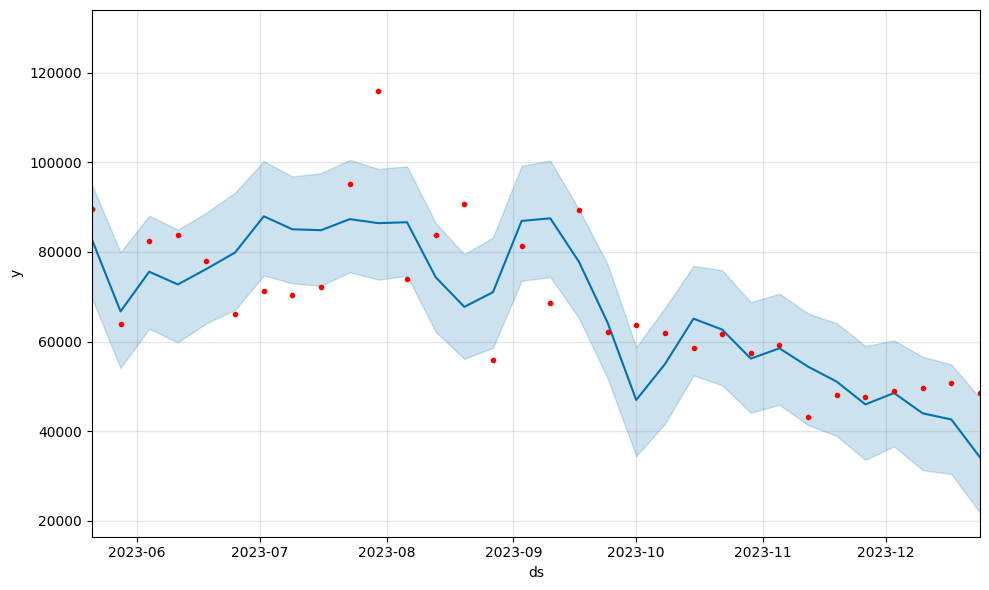

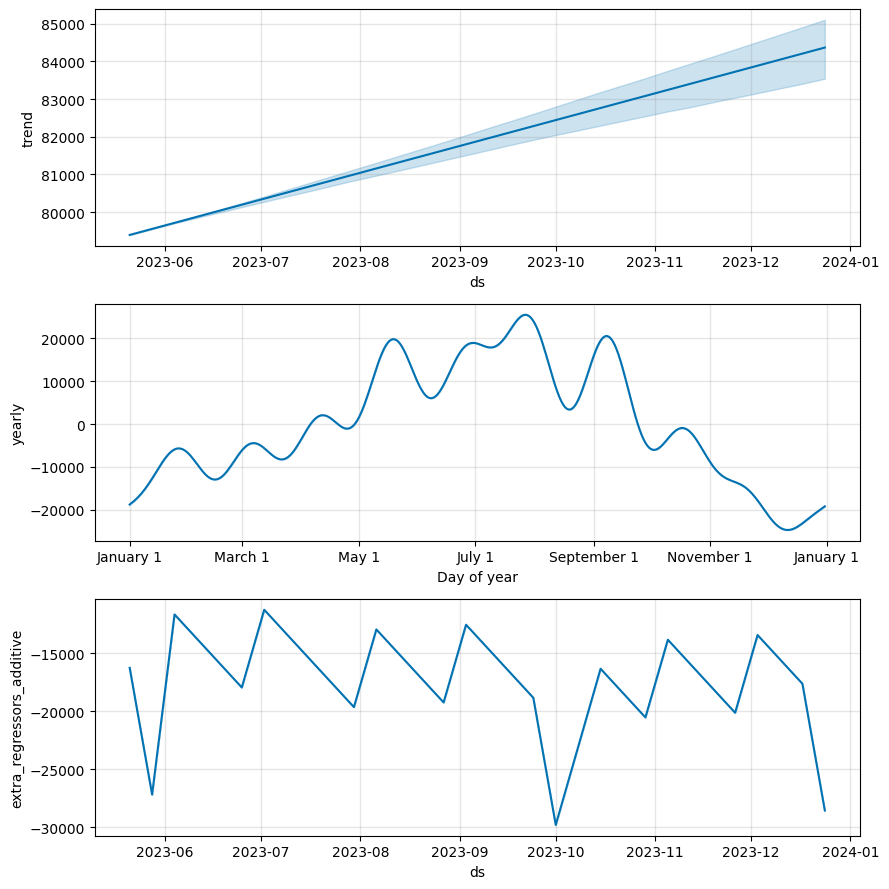

In [230]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 테스트 기간만 필터링
forecast_test_period = forecast[forecast['ds'].isin(test_df['ds'])]

# 전체 예측 결과를 시각화
fig = model.plot(forecast)
# x축의 범위를 테스트 기간으로 제한
plt.xlim([test_df['ds'].min(), test_df['ds'].max()])
# 테스트 데이터 실제값 추가
plt.plot(test_df['ds'], test_df['y'], 'r.', label='Actual')
# 그래프 표시
plt.show()

# Plotly를 사용하여 컴포넌트 시각화
fig_components = model.plot_components(forecast_test_period)
fig_components.show()

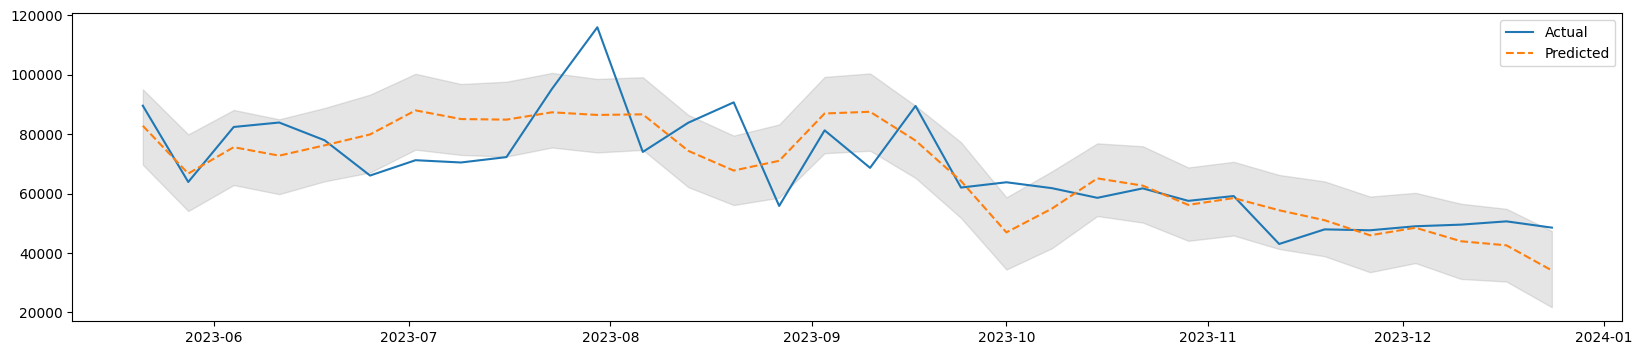

In [231]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

forecast = forecast.sort_values(by='ds')
test_df = test_df.sort_values(by='ds')
# 실제값과 예측값 병합
result = test_df.copy()
result['yhat'] = forecast.set_index('ds').loc[test_df['ds']]['yhat'].values

# 예측 결과 시각화
plt.figure(figsize=(20, 4))
plt.plot(result['ds'], result['y'], label='Actual')
plt.plot(result['ds'], result['yhat'], label='Predicted', linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
plt.legend()
plt.show()

In [232]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# Forecasting on test data
forecast = model.predict(future)

# Evaluate MAE
mae = mean_absolute_error(test_df['y'], forecast['yhat'][-len(test_df):])
print(f"MAE: {mae}")

# Evaluate RMSE
rmse = np.sqrt(mean_squared_error(test_df['y'], forecast['yhat'][-len(test_df):]))
print(f"RMSE: {rmse}")

# Evaluate R2
r2 = r2_score(test_df['y'], forecast['yhat'][-len(test_df):])
print(f"R2 Score: {r2}")


MAE: 9406.341734796735
RMSE: 11675.986207083617
R2 Score: 0.5111849253128409


In [225]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 10.0, 20.0],
    'holidays_prior_scale': [1.0, 5.0, 10.0]
}
grid = ParameterGrid(param_grid)

best_mae = float('inf')
best_params = None

for params in grid:
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale=params['seasonality_prior_scale'],
                    holidays_prior_scale=params['holidays_prior_scale'])
    model.fit(train_df)
    future = model.make_future_dataframe(periods=len(test_df))
    forecast = model.predict(future)
    mae = mean_absolute_error(test_df['y'], forecast['yhat'][-len(test_df):])
    if mae < best_mae:
        best_mae = mae
        best_params = params

print("Best Parameters:", best_params)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgxawqzgz/989kb_tt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgxawqzgz/13xqhy5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10388', 'data', 'file=/tmp/tmpgxawqzgz/989kb_tt.json', 'init=/tmp/tmpgxawqzgz/13xqhy5i.json', 'output', 'file=/tmp/tmpgxawqzgz/prophet_modelxr8rhm33/prophet_model-20241213175909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

Best Parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}
